# Predicting Missing Fitbit Data

## Summary of Findings

---
## Project Plan

### Goals
 - Predict missing values from the data set using clustering
 - Derive insights on "Armstrong", the person from whom the fitness data was generated

### Hypotheses
 - There are patterns on Armstrong's daily activities.
 - Armstrong's fitness activity is affected by the month/season of the year.

### Data Science Skills Used
 - Data prep and cleaning
 - Time Series Analysis
 - Visualization
 - Modeling using Parametric Methods
 - Modeling using the Prophet algorithm
 - Evaluation of Models

---
## Data Dictionary

---
## Notes on the Fitbit Data:

We are given eight .csv files that hold monthly data of an individual, whom we elect to call "Armstrong". Before we begin wrangling the data, we peruse all the files and made initial notes as follows:

1. The "missing" data is from 6/27/2018 - 7/6/2018 on the following variables:
  - Steps
  - Distance
  - Floors
  - Lightly Active in Minutes
  - Fairly Active in Minutes
  - Very Active in Minutes
2. Food/ Food log data is almost empty. There are only 1 record available in May-June data, and 7 records in the October-November data.
3. The data range covers April 26, 2018 to December 6, 2018.

### Packages

In [18]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
#import prepare
#import summarize
#from acquire import get_store_data
#from prepare import prep_store_data, split_store_data
# from summarize import df_summary

## I. Acquire and Preprocess

We manipulated the individual csv files from Excel, and decided to create a single .csv file as the size of the data is manageable. We only wanted the activity data, and not the food/food log data which barely contain any data.

`act.csv` is the csv file that integrates all relevant activitiy data from the eight .csv files provided.

The `acquire` function from the acquire.py module produces a data frame out of `act.csv` and renames the columns for efficiency.

In [111]:
df = pd.read_csv('act.csv', header=0,usecols=[0,1,2,3,4,5,6,7,8,9],names=["date","cal_burn","steps","distance","floors","min_sed","min_active_light","min_active_fairly","min_active_very","cal_activity"])

In [112]:
df.head()

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [113]:
# #### acquire function broke!!!
# df = acquire.acquire()

# #Initial look at the data.
# #Catch presence of nulls and inappropriate data types
# df.info()

Apart from `date` which will be handled later, there are four columns that are object type.
 - cal_burn
 - steps
 - min_sed
 - cal_activity

In [114]:
df.sample(5) #inspect the object-type attributes

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
45,6/10/18,"3,432","7,029",3.32,7,728,230,35,9,"1,549"
49,6/14/18,"3,533","8,316",3.92,10,591,287,22,1,"1,684"
139,9/12/18,"3,047","7,512",3.54,6,676,179,17,13,"1,175"
22,5/18/18,"4,376","13,958",6.58,7,682,178,67,92,"2,549"
57,6/22/18,"3,290","5,805",2.74,3,"1,179",235,2,9,"1,278"


It seems that commas are making these numeric attributes as object types. To remove commas and cast these columns from object into integer types, call the `handle_obj_type` function from the acquire.py module.

In [115]:
df = acquire.handle_obj_type(df)

In [116]:
train = (df.loc[:int(len(df)*.70)])
test = (df.loc[train.shape[0]:])

In [117]:
train.head()

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
0,4/26/18,2635,2931,1.38,2,1347,93,0,0,566
1,4/27/18,3649,9971,4.70,19,1158,219,46,17,1752
2,4/28/18,3379,3521,1.66,2,702,155,22,11,1124
3,4/29/18,2851,1639,0.77,0,891,122,0,0,602
4,4/30/18,2825,1323,0.62,0,880,104,0,0,540


In [118]:
train.date = pd.to_datetime(train.date)
test.date = pd.to_datetime(test.date)
train = train.set_index("date")
test = test.set_index("date")

Finally, to facilitate our analysis, cast `date` column into datetime data type, and set it as the index of our data frame. Call `basic_clean` function to execute these, as well as validate that the days are distinct, i.e. no duplicate records.

### Split Data

Split the data into train and test using the `split_date` from the acquire module.
  
**Composition of Test and Train**    
**Test**
 - April 26 to July 15, 2018
 - Includes the period of missing values, June 27 to July 6, 2018  

**Train**
 - July 16 to Dec 6, 2018

In [119]:
train.head()

,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124
2018-04-29,2851,1639,0.77,0,891,122,0,0,602
2018-04-30,2825,1323,0.62,0,880,104,0,0,540


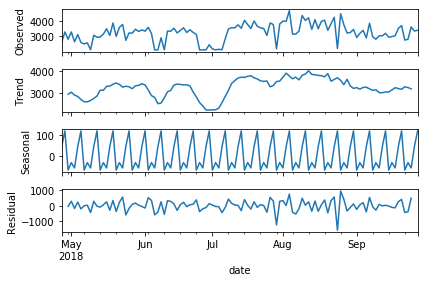

In [120]:
decomposition = sm.tsa.seasonal_decompose(train.cal_burn.resample("B").mean(), model='additive')

fig = decomposition.plot()
plt.show()

In [121]:
train.head()

,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
date,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124
2018-04-29,2851,1639,0.77,0,891,122,0,0,602
2018-04-30,2825,1323,0.62,0,880,104,0,0,540


Calories Burn and Activity Calories are related.
Confirms Hypothesis that we can use the BMR calculation to impute missing values on Activity Calories.
-formula

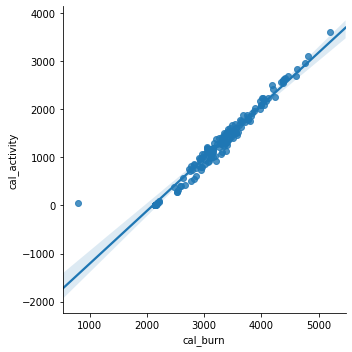

In [122]:
sns.lmplot(data=train,x="cal_burn",y="cal_activity")

#### Imputation

Impute `cal_activity` using BMR formula.

Process:
1. Get median_bmr
2. Subset the week with missing values.
3. If the cal_activity = 0, impute calculated cal_activity using the formula. Otherwise, use the actual cal_activity value.

In [123]:
median_bmr = (train.cal_burn - train.cal_activity).median()
median_bmr

1986.0

In [124]:
#add a column in train with a computed cal_activity based on formula
train["calculated_cal_activity"] = train.cal_burn - median_bmr

#subset the days with missing values
missing_subset = train["2018-06-26":"2018-07-06"]

#use np.where to replace 0 with calculated cal_activity, and retain actual values if not 0.
missing_subset["cal_activity"] = np.where(missing_subset.cal_activity == 0, missing_subset.calculated_cal_activity, missing_subset.cal_activity)

In [125]:
#attach the subset back to train
train.loc["2018-06-26":"2018-07-06","cal_activity"] = missing_subset.cal_activity

In [126]:
train["2018-06-26":"2018-07-06"]

,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity,calculated_cal_activity
date,,,,,,,,,,
2018-06-26,2144,0,0.00,0,1440,0,0,0,158.0,158.0
2018-06-27,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-06-28,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-06-29,2180,0,0.00,0,1437,3,0,0,39.0,194.0
2018-06-30,2145,0,0.00,0,1440,0,0,0,159.0,159.0
2018-07-01,3090,4714,2.22,4,1005,232,0,0,1125.0,1104.0
2018-07-02,2204,172,0.08,0,1024,12,0,0,67.0,218.0
2018-07-03,2144,0,0.00,0,1440,0,0,0,158.0,158.0
2018-07-04,2183,0,0.00,0,1438,2,0,0,42.0,197.0


Next, impute missing values on the following attributes:
- `steps`
- `distance`
- `floors`
- `min_active_light`
- `min_active_fairly`
- `min_active_very`

Unlike the `cal_activity` with heavy interdependence with known values in `cal_burn` (i.e., using BMR), the attributes above can be calculated using the mean of observations with similar daily profile to the ones missing.

The days with missing values can be loosely described as "Lazy Days" where the `cal_burn` and `cal_activity` values are below the median. Specifically, the days with missing values have cal_burn of 2000-2500, when the median `cal_burn` is 3302.5 in train.

With these in mind, we decide the imputation process to be as follows:
 1. Find similar-looking "Lazy Days" observations.
 2. Limit the observations with similar-looking "Lazy Days", that is, with cal_burn between 2000-2500.
 3. Get the mean values of attributes of "Lazy Days". These values are going to be the imputed constants for our missing values.
 5. Excluding values from July 1 and 2, 2018 which contain true values, impute the mean constants.

In [164]:
#Steps Mean Constant
mean_lds_steps = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].steps.mean()

#Distance Mean Constant
mean_lds_distance = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].distance.mean()

#Floors Mean Constant
mean_lds_floor = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].floors.mean()

#Lightly Active Minutes Mean Constant
mean_lds_light = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_light.mean()

#Fairly Active Minutes Mean Constant
mean_lds_fairly = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_fairly.mean()

#Very Active Minutes Mean Constant
mean_lds_very = train[(train.cal_burn < 2500) & (train.cal_burn > 2000)].min_active_very.mean()

In [187]:
missing_subset_21 = train["2018-06-26":"2018-06-30"]
missing_subset_22 = train["2018-07-03":"2018-07-06"]

In [188]:
missing_subset_21["steps"] = mean_lds_steps
missing_subset_21["distance"] = mean_lds_steps
missing_subset_21["floors"] = mean_lds_steps
missing_subset_21["min_active_light"] = mean_lds_light
missing_subset_21["min_active_fairly"] = mean_lds_fairly
missing_subset_21["min_active_very"] = mean_lds_very

In [191]:
missing_subset_22["steps"] = mean_lds_steps
missing_subset_22["distance"] = mean_lds_steps
missing_subset_22["floors"] = mean_lds_steps
missing_subset_22["min_active_light"] = mean_lds_light
missing_subset_22["min_active_fairly"] = mean_lds_fairly
missing_subset_22["min_active_very"] = mean_lds_very

In [192]:
missing_subset_22

,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity,calculated_cal_activity
date,,,,,,,,,,
2018-07-03,2144,149.823529,149.823529,149.823529,1440,7.235294,0.0,0.0,158.0,158.0
2018-07-04,2183,149.823529,149.823529,149.823529,1438,7.235294,0.0,0.0,42.0,197.0
2018-07-05,2153,149.823529,149.823529,149.823529,1439,7.235294,0.0,0.0,10.0,167.0
2018-07-06,2144,149.823529,149.823529,149.823529,1440,7.235294,0.0,0.0,158.0,158.0


In [195]:
#attach the missing_subset_21 and 22 back to train
train.loc["2018-06-26":"2018-06-30"] = missing_subset_21
train.loc["2018-07-03":"2018-07-06"] = missing_subset_22

## II. Explore

**Questions**

1. Are there any day of the week where Armstrong is particularly more active or sedentary?
2. Do Armstrong have weekly patterns of activity?
3. During which months is Armstrong more/less active?
4. What is Armstrong's average statistics? Use moving average, so non or less-active/non or less-recorded days will not affect the overall averages of :
  - Calories burned
  - Steps taken
  - Distance
  - Floors
  - Sedentary or not active in minutes
  - Lightly active in minutes
  - Very active in minutes
  - Calories burned by activity
5. Is Armstrong more active in a particular season of the year (cool, hot, cold months)?
6. What is Armstrong's time series decompostion look like?
7. What is Armstrong's daily and weekly activity frequencies look like?
8. What's the correlation between activity from yesterday-today (lag)?

In [ ]:
train_month = train.resample("M").mean()

In [ ]:
train.columns

In [ ]:
train_month.index.unique()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['cal_burn','steps','distance','floors']], marker='o')
plt.legend(['cal_burn', 'steps','distance','floors'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xticks(["2018-0","2018-11","2018-10","2018-09","2018-08"],["Dec","Nov","Oct","Sept","Aug","Jul"])

plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['min_sed', 'min_active_light','min_active_fairly','min_active_very']], marker='o')
plt.legend(['min_sed','min_active_light', 'min_active_fairly', 'min_active_very'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-08","2018-09","2018-10","2018-11","2018-12"],["Jul","Aug","Sep","Oct","Nov","Dec"])

plt.show()

<div class="alert alert-block alert-warning">
<b>Answer:</b>
Armstrong has a generally sedentary lifestyle with an activity level of "light". We see a heightened steps count in Oct-Dec (colder months). He was least active in July and September, which are summer months.
</div>

In [ ]:
decomposition = sm.tsa.seasonal_decompose(train.cal_burn.resample("D").mean(), model='additive')

fig = decomposition.plot()
plt.show()

In [ ]:
# sns.barplot(x=train_month.index, y="cal_burn", data=train_month, palette=["gray"]*6)

for att in train.columns:
    train.groupby(train.index.month)[att].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.title(f"{att} by month")
    plt.show()
# flights.groupby('weekday').delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# # flights.groupby(flights.index.weekday_name).delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# plt.xticks(rotation=0)

## III. Model

In [ ]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

In [ ]:
# create df to store MSE & RMSE
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [ ]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

# plot_and_eval(target_vars, train, test)
# eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    yhat['y'] = train.y.rolling(p).mean().iloc[-1]
    plt.plot(yhat.y)
    print('\nrolling averge period:',p)
    print('\nitem sales\n')
    evaluate('y', train = train, test = test)